# Siegert neuron integration

#### Alexander van Meegen, 2020-12-03

This notebook describes how NEST handles the numerical integration of the 'Siegert' function.

For an alternative approach, which was implemented in NEST before, see Appendix A.1 in ([Hahne et al., 2017](https://www.frontiersin.org/articles/10.3389/fninf.2017.00034/full#h10)). The current approach seems to be faster and more stable, in particular in the noise-free limit.

Let's start with some imports:

In [1]:
import numpy as np
from scipy.special import erf, erfcx
import matplotlib.pyplot as plt

## Introduction

We want to determine the firing rate of an integrate-and-fire neuron with exponentially decaying post–synaptic currents driven by a mean input $\mu$ and white noise of strength $\sigma$. For small synaptic time constant $\tau_{\mathrm{s}}$ compared to the membrane time constant $\tau_{\mathrm{m}}$, the firing rate is given by the 'Siegert' ([Fourcaud and Brunel, 2002](https://doi.org/10.1162/089976602320264015))

$$ \phi(\mu,\sigma)	=	\left(\tau_{\mathrm{ref}}+\tau_{\mathrm{m}}\sqrt{\pi}I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})\right)^{-1} $$

with the refractory period $\tau_{\mathrm{ref}}$ and the integral

$$ I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})	=	\int_{\tilde{V}_{\mathrm{r}}}^{\tilde{V}_{\mathrm{th}}}e^{s^{2}}(1+\mathrm{erf}(s))ds $$

involving the shifted and scaled threshold voltage $\tilde{V}_{\mathrm{th}}=\frac{V_{\mathrm{th}}-\mu}{\sigma}+\frac{\alpha}{2}\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}$, the shifted and scaled reset voltage $\tilde{V}_{\mathrm{r}}=\frac{V_{\mathrm{r}}-\mu}{\sigma}+\frac{\alpha}{2}\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}$, and the constant $\alpha=\sqrt{2}\left|\zeta(1/2)\right|$ where $\zeta(x)$ denotes the Riemann zeta function. 

Numerically, the integral in $I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})$ is problematic due to the interplay of $e^{s^{2}}$ and $\mathrm{erf}(s)$ in the integrand. Already for moderate values of $s$, it causes numerical problems (note the order of magnitude):

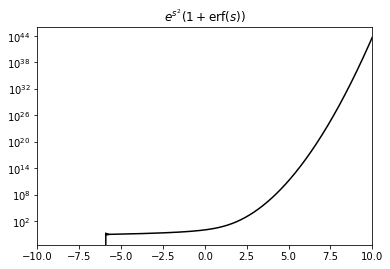

In [2]:
s = np.linspace(-10, 10, 1001)
plt.plot(s, np.exp(s**2) * (1 + erf(s)), c='black')
plt.xlim(s[0], s[-1])
plt.yscale('log')
plt.title(r'$e^{s^{2}}(1+\mathrm{erf}(s))$')
plt.show()

The main trick here is to use the [scaled complementary error function](https://en.wikipedia.org/wiki/Error_function#Complementary_error_function)

$$\mathrm{erf}(s)=1-e^{-s^{2}}\mathrm{erfcx}(s)$$

to extract the leading exponential contribution. For positive $s$, we have $0\le\mathrm{erfcx}(s)\le1$, i.e. the exponential contribution is in the prefactor $e^{-s^{2}}$ which nicely cancels with the $e^{s^{2}}$ in the integrand. In the following, we separate three cases according to the sign of $\tilde{V}_{\mathrm{th}}$ and $\tilde{V}_{\mathrm{r}}$ because for a negative arguments, the integrand simplifies to $e^{s^{2}}(1+\mathrm{erf}(-s))=\mathrm{erfcx}(s)$. Eventually, only integrals of $\mathrm{erfcx}(s)$ for positive $s\ge0$ need to be solved numerically which are certainly better behaved:

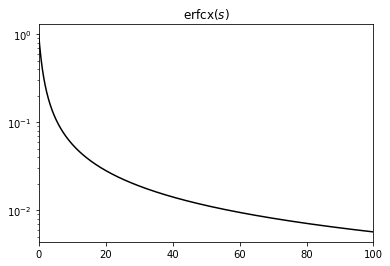

In [3]:
s = np.linspace(0, 100, 1001)
plt.plot(s, erfcx(s), c='black')
plt.xlim(s[0], s[-1])
plt.yscale('log')
plt.title(r'$\mathrm{erfcx}(s)$')
plt.show()

## Mathematical Reformulation

### Strong Inhibition

We have to consider three different cases; let us start with strong inhibitory input such that $0<\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}$ or equivalently $\mu<V_{\mathrm{r}}+\frac{\alpha}{2}\sigma\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}$. In this regime, the error function in the integrand is positive. Expressing it in terms of $\mathrm{erfcx}(s)$, we get

$$I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})=2\int_{\tilde{V}_{\mathrm{r}}}^{\tilde{V}_{\mathrm{th}}}e^{s^{2}}ds-\int_{\tilde{V}_{\mathrm{r}}}^{\tilde{V}_{\mathrm{th}}}\mathrm{erfcx}(s)ds. $$

The first integral can be solved in terms of the Dawson function $D(s)$, which is bound between $\pm1$ and conveniently implemented in GSL; the second integral gives a small correction which has to be evaluated numerically. We get

$$I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})=2e^{\tilde{V}_{\mathrm{th}}^{2}}D(\tilde{V}_{\mathrm{th}})-2e^{\tilde{V}_{\mathrm{r}}^{2}}D(\tilde{V}_{\mathrm{r}})-\int_{\tilde{V}_{\mathrm{r}}}^{\tilde{V}_{\mathrm{th}}}\mathrm{erfcx}(s)ds.$$

We extract the leading contribution $e^{\tilde{V}_{\mathrm{th}}^{2}}$ from the denominator and arrive at

$$\phi(\mu,\sigma)=\frac{e^{-\tilde{V}_{\mathrm{th}}^{2}}}{e^{-\tilde{V}_{\mathrm{th}}^{2}}\tau_{\mathrm{ref}}+\tau_{\mathrm{m}}\sqrt{\pi}\left(2D(\tilde{V}_{\mathrm{th}})-2e^{-\tilde{V}_{\mathrm{th}}^{2}+\tilde{V}_{\mathrm{r}}^{2}}D(\tilde{V}_{\mathrm{r}})-e^{-\tilde{V}_{\mathrm{th}}^{2}}\int_{\tilde{V}_{\mathrm{r}}}^{\tilde{V}_{\mathrm{th}}}\mathrm{erfcx}(s)ds\right)}$$

as a numerically safe expression for $0<\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}$. Extracting $e^{\tilde{V}_{\mathrm{th}}^{2}}$ from the denominator reduces the latter to $2\tau_{\mathrm{m}}\sqrt{\pi}D(\tilde{V}_{\mathrm{th}})$ and exponentially small correction terms because $\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}$, thereby preventing overflow.

### Strong Excitation

Now let us consider the case of strong excitatory input such that $\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}<0$ or $\mu>V_{\mathrm{th}}+\frac{\alpha}{2}\sigma\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}$. In this regime, we can change variables $s\to-s$ to make the domain of integration positive again. Using $\mathrm{erf}(-s)=-\mathrm{erf}(s)$ as well as $\mathrm{erfcx}(s)$, we get

$$I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})=\int_{|\tilde{V}_{\mathrm{th}}|}^{|\tilde{V}_{\mathrm{r}}|}\mathrm{erfcx}(s)ds.$$

In particular, there is no exponential contribution involved in this regime. Thus, we get

$$\phi(\mu,\sigma)=\frac{1}{\tau_{\mathrm{ref}}+\tau_{\mathrm{m}}\sqrt{\pi}\int_{|\tilde{V}_{\mathrm{th}}|}^{|\tilde{V}_{\mathrm{r}}|}\mathrm{erfcx}(s)ds}$$

as a numerically safe expression for $\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}<0$.

### Intermediate Regime

In the intermediate regime, we have $\tilde{V}_{\mathrm{r}}\le0\le\tilde{V}_{\mathrm{th}}$ or $V_{\mathrm{r}}+\frac{\alpha}{2}\sigma\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}\le\mu\le V_{\mathrm{th}}+\frac{\alpha}{2}\sigma\sqrt{\frac{\tau_{\mathrm{s}}}{\tau_{\mathrm{m}}}}$. Thus, we split the integral at zero and use the previous steps for the respective parts to get

$$I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})=2e^{\tilde{V}_{\mathrm{th}}^{2}}D(\tilde{V}_{\mathrm{th}})+\int_{\tilde{V}_{\mathrm{th}}}^{|\tilde{V}_{\mathrm{r}}|}\mathrm{erfcx}(s)ds.$$

Note that the sign of the second integral depends on whether $\left|\tilde{V}_{\mathrm{r}}\right|>\tilde{V}_{\mathrm{th}}$ (+) or not (-). Again, we extract the leading contribution $e^{\tilde{V}_{\mathrm{th}}^{2}}$ from the denominator and arrive at

$$\phi(\mu,\sigma)	=	\frac{e^{-\tilde{V}_{\mathrm{th}}^{2}}}{e^{-\tilde{V}_{\mathrm{th}}^{2}}\tau_{\mathrm{ref}}+\tau_{\mathrm{m}}\sqrt{\pi}\left(2D(\tilde{V}_{\mathrm{th}})+e^{-\tilde{V}_{\mathrm{th}}^{2}}\int_{\tilde{V}_{\mathrm{th}}}^{|\tilde{V}_{\mathrm{r}}|}\mathrm{erfcx}(s)ds\right)}$$

as a numerically safe expressions for $\tilde{V}_{\mathrm{r}}\le0\le\tilde{V}_{\mathrm{th}}$.

## Noise-free Limit

Even the noise-free limit $\sigma\ll\mu$, where the implementation from ([Hahne et al., 2017](https://www.frontiersin.org/articles/10.3389/fninf.2017.00034/full#h10)) eventually breaks, works flawlessly. In this limit, $\left|\tilde{V}_{\mathrm{th}}\right|\gg1$ as long as $\mu\neq V_{\mathrm{th}}$; thus, we get both in the 'strong inhibition' and in the 'itermediate' regime $\phi(\mu,\sigma)\sim e^{-\tilde{V}_{\mathrm{th}}^{2}}\approx0$ for $\tilde{V}_{\mathrm{th}}\ge0$. Accordingly, the only interesting case is the 'strong excitation' regime $\tilde{V}_{\mathrm{r}}<\tilde{V}_{\mathrm{th}}<0$. Since also $\left|\tilde{V}_{\mathrm{r}}\right|\gg1$, the integrand $\mathrm{erfcx}(s)$ is only evaluated at $s\gg1$. Using the only the first term of the [asymptotic expansion](https://en.wikipedia.org/wiki/Error_function#Asymptotic_expansion)

$$\mathrm{erfcx}(s)=\frac{1}{s\sqrt{\pi}}\sum_{n=0}^{\infty}(-1)^{n}\frac{(2n-1)!!}{(2s^{2})^{n}}$$

leads to the analytically solvable integral

$$I(\tilde{V}_{\mathrm{th}},\tilde{V}_{\mathrm{r}})=\int_{|\tilde{V}_{\mathrm{th}}|}^{|\tilde{V}_{\mathrm{r}}|}\mathrm{erfcx}(s)ds\approx\frac{1}{\sqrt{\pi}}\int_{|\tilde{V}_{\mathrm{th}}|}^{|\tilde{V}_{\mathrm{r}}|}\frac{1}{s}ds=\frac{1}{\sqrt{\pi}}\log\frac{\left|\tilde{V}_{\mathrm{r}}\right|}{\left|\tilde{V}_{\mathrm{th}}\right|}.$$

Inserting this into $\phi(\mu,\sigma)$ and using $\tilde{V}_{\mathrm{th}}\approx\frac{V_{\mathrm{th}}-\mu}{\sigma}, \tilde{V}_{\mathrm{r}}\approx\frac{V_{\mathrm{r}}-\mu}{\sigma}$ yields

$$\phi(\mu,\sigma)\approx\begin{cases}
0 & \mu\le V_{\mathrm{th}}\\
\frac{1}{\tau_{\mathrm{ref}}+\tau_{\mathrm{m}}\log\frac{\mu-V_{\mathrm{r}}}{\mu-V_{\mathrm{th}}}} & \mu>V_{\mathrm{th}}\end{cases}$$

[as it should](https://neuronaldynamics.epfl.ch/online/Ch8.S3.html). Thus, as long as the numerical solution of the integral $\frac{1}{\sqrt{\pi}}\int_{|\tilde{V}_{\mathrm{th}}|}^{|\tilde{V}_{\mathrm{r}}|}\frac{1}{s}ds$ is precise, the deterministic limit is also numerically safe.

### Relevance of Noise-free Limit

Let us briefly estimate for which values the noise-free limit becomes relevant. We have $\left|\tilde{V}_{\mathrm{r}}\right|>\left|\tilde{V}_{\mathrm{th}}\right|\gg1$, thus the integrand $\mathrm{erfcx}(s)$ is only evaluated for arguments $s>\left|\tilde{V}_{\mathrm{th}}\right|\gg1$. Looking at the difference between $\mathrm{erfcx}(s)$ and the first order asymptotics shown below, we see that the absolute difference to the asymptotics is only $O(10^{-7})$ for moderate values $\left|\tilde{V}_{\mathrm{th}}\right|\approx O(100)$. Since we saw above that the noise free limit is equivalent to the first order asymptotics, we can conclude that it is certainly relevant for $\left|\tilde{V}_{\mathrm{th}}\right|\approx\frac{\mu-V_{\mathrm{th}}}{\sigma}\approx O(100)$; e.g. for $\mu-V_{\mathrm{th}}\approx10$mV a noise strength of $\sigma\approx0.1$mV corresponds to the noise-free limit.

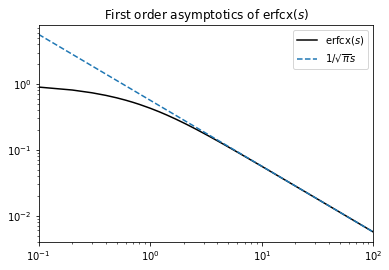

In [4]:
s = np.linspace(0.1, 100, 1000)
plt.plot(s, erfcx(s), c='black', label=r'$\mathrm{erfcx}(s)$')
plt.plot(s, 1/(np.sqrt(np.pi)*s), ls='--', label=r'$1/\sqrt{\pi}s$')
plt.xlim(s[0], s[-1])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'First order asymptotics of $\mathrm{erfcx}(s)$')
plt.show()

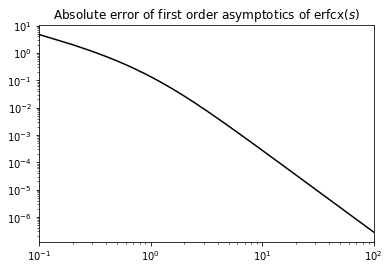

In [5]:
s = np.linspace(0.1, 100, 1000)
plt.plot(s, 1/(np.sqrt(np.pi)*s)-erfcx(s), c='black')
plt.xlim(s[0], s[-1])
plt.xscale('log')
plt.yscale('log')
plt.title(r'Absolute error of first order asymptotics of $\mathrm{erfcx}(s)$')
plt.show()